In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In [2]:
dataset = load_boston()
print(dataset.data[:3])

[[6.3200e-03 1.8000e+01 2.3100e+00 0.0000e+00 5.3800e-01 6.5750e+00
  6.5200e+01 4.0900e+00 1.0000e+00 2.9600e+02 1.5300e+01 3.9690e+02
  4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 6.4210e+00
  7.8900e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9690e+02
  9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 7.1850e+00
  6.1100e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9283e+02
  4.0300e+00]]


In [3]:
# 506 * 13 = 6578 个数据
print(dataset.data.shape)

(506, 13)


In [4]:
x_full, y_full = dataset.data, dataset.target
n_samples = x_full.shape[0]
n_features = x_full.shape[1]

# 放入缺失值

In [5]:
rng = np.random.RandomState(0)

# 缺失值比例
# np.floor 下取整, 返回 .0 浮点数
missing_rate = 0.5
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))
print(n_missing_samples)

3289


- 所有数据要随机分布在数据集的各行各列
- 一个缺失值需要一个行索引和一个列索引

- `rng.randint` 是有重复抽样
- `rng.choice(n_samples, n_missing_samples, replace=False)` 随机抽取不重复的随机数

In [6]:
missing_features = rng.randint(0, n_features, n_missing_samples)
missing_samples = rng.randint(0, n_samples, n_missing_samples)

In [7]:
len(missing_features), len(missing_samples)

(3289, 3289)

In [8]:
x_missing = x_full.copy()
y_missing = y_full.copy()

# 赋缺失值

In [9]:
x_missing[missing_samples, missing_features] = np.nan

In [10]:
pd.DataFrame(x_missing)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.90,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,69.1,NaN,1.0,NaN,21.0,NaN,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,NaN,396.90,9.08
503,NaN,NaN,11.93,NaN,0.573,6.976,91.0,NaN,NaN,NaN,21.0,NaN,5.64
504,0.10959,0.0,11.93,NaN,0.573,NaN,89.3,NaN,1.0,NaN,21.0,393.45,6.48


# 均值填补

In [11]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
x_missing_mean = imp_mean.fit_transform(x_missing)
print(x_missing_mean[:3])

[[3.62757895e+00 1.80000000e+01 1.11634641e+01 6.60066007e-02
  5.38000000e-01 6.30592131e+00 6.52000000e+01 4.09000000e+00
  1.00000000e+00 2.96000000e+02 1.85211921e+01 3.52741952e+02
  4.98000000e+00]
 [2.73100000e-02 0.00000000e+00 1.11634641e+01 0.00000000e+00
  4.69000000e-01 6.30592131e+00 7.89000000e+01 4.96710000e+00
  2.00000000e+00 4.05935275e+02 1.85211921e+01 3.96900000e+02
  9.14000000e+00]
 [2.72900000e-02 1.07229508e+01 7.07000000e+00 0.00000000e+00
  5.64128289e-01 7.18500000e+00 6.11000000e+01 3.85637087e+00
  2.00000000e+00 2.42000000e+02 1.85211921e+01 3.52741952e+02
  1.29917666e+01]]


# 常数值零填补

In [12]:
imp_0 = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)
x_missing_0 = imp_0.fit_transform(x_missing)

# 随机森林填补缺失值
- 任何回归都是从特征矩阵中学习，然后求解连续性标签 y 的过程
- 回归算法认为特征矩阵和标签之间存在联系，可以从特征预测标签，反过来，也可以从标签预测特征

- 对于 N 个特征的数据，特征 T 有缺失值，就把 T 当做标签与其他的 N - 1 个特征和原本的标签组成新的特征矩阵
- 对于 T 来说
  - 没有缺失的部分就是 YTest，这部分既有特征又有标签
  - 有缺失的部分，只有特征没有标签，这是需要预测的部分

特征 T 不缺失的值，对应的其它 n - 1 个特征加标签 -> XTrain
特征 Y 不缺失的值 -> YTrain

特征 T 缺失的值，对应的其它的 n - 1 个特征加标签 -> XTest
特征 T 缺失的值，位置，需要预测的 YTest

从缺失值数量从小到大遍历特征，填补某个特征时，其它特征中的缺失值先用零代替

In [13]:
x_missing = pd.DataFrame(x_missing)
x_missing_reg = x_missing.copy()
print(x_missing_reg[:3])

        0     1     2    3      4      5     6       7    8      9   10  \
0      NaN  18.0   NaN  NaN  0.538    NaN  65.2  4.0900  1.0  296.0 NaN   
1  0.02731   0.0   NaN  0.0  0.469    NaN  78.9  4.9671  2.0    NaN NaN   
2  0.02729   NaN  7.07  0.0    NaN  7.185  61.1     NaN  2.0  242.0 NaN   

      11    12  
0    NaN  4.98  
1  396.9  9.14  
2    NaN   NaN  


- 找出数据集中，缺失值数目从小到大排序的特征顺序
- 用 np.argsort 排序 pd 表

In [14]:
sortindex = np.argsort(x_missing_reg.isnull().sum(axis=0)).values
sortindex

array([ 6, 12,  8,  7,  9,  0,  2,  1,  5,  4,  3, 10, 11])

In [15]:
for i in sortindex:
    # 构建新的特征矩阵和新标签
    df = x_missing_reg
    fillc = df.iloc[:, i] # 新标签
    df = pd.concat([df.iloc[:, df.columns != i], pd.DataFrame(y_full)], axis=1) # 新特征    
    # 在新特征矩阵中，对含有缺失值的列，用 0 填补
    df_0 = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0).fit_transform(df)
    
    # 找出训练集和测试机
    YTrain = fillc[fillc.notnull()]
    YTest = fillc[fillc.isnull()]
    XTrain = df_0[YTrain.index, :]
    XTest = df_0[YTest.index, :]
    
    # 回归
    rfc = RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(XTrain, YTrain)
    YPredict = rfc.predict(XTest)
    
    # 填充
    x_missing_reg.loc[x_missing_reg.iloc[:, i].isnull(), i] = YPredict

# kNN 填缺失值

##  使用 `fancyimpute` 

In [16]:
from fancyimpute import KNN

x_missing_knn = np.array(x_missing.copy()) # 含缺失值的数据

x_missing_knn = KNN(k=3).fit_transform(x_missing_knn)

Imputing row 1/506 with 6 missing, elapsed time: 0.066
Imputing row 101/506 with 6 missing, elapsed time: 0.075
Imputing row 201/506 with 3 missing, elapsed time: 0.083
Imputing row 301/506 with 6 missing, elapsed time: 0.094
Imputing row 401/506 with 5 missing, elapsed time: 0.101
Imputing row 501/506 with 3 missing, elapsed time: 0.110


# 用填补好的数据进行建模

In [17]:
from sklearn.model_selection import cross_val_score

X = [x_full, x_missing_0, x_missing_mean, x_missing_reg, x_missing_knn]

mse = []
std = []

for x in X:
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    scores = cross_val_score(estimator, x, y_full, scoring="neg_mean_squared_error", cv=5).mean()
    mse.append(scores * -1)

In [18]:
x_labels = ["Full data"
            ,"Zero Imputation"
            ,"Mean Imputation"
            ,"Regressor Imputation"
            ,"KNN Imputation"
           ]
[*zip(x_labels, mse)]

[('Full data', 21.571667100368845),
 ('Zero Imputation', 49.626793201980185),
 ('Mean Imputation', 40.848037216676374),
 ('Regressor Imputation', 19.065235040438743),
 ('KNN Imputation', 40.61141850062124)]

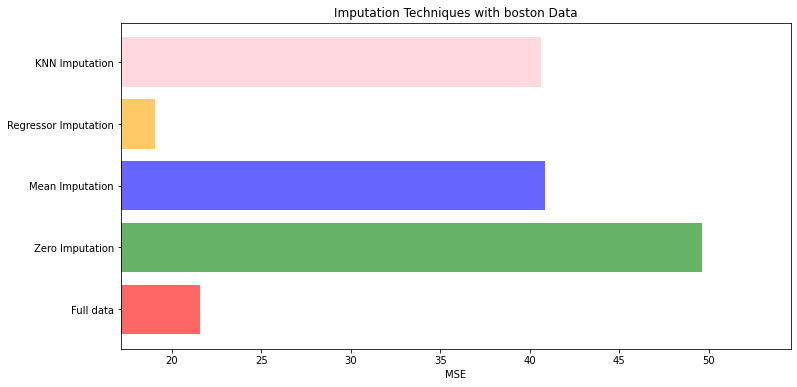

In [19]:
colors = ['r', 'g', 'b', 'orange', "pink"]

plt.figure(figsize=(12, 6)) # 画出画布
ax = plt.subplot(111) # 添加子图 (第一行第一列第一个表)
for i in np.arange(len(mse)):
    # 条形图： barh 是横过来的
    ax.barh(i, mse[i], color=colors[i], alpha=0.6, align="center")
ax.set_title("Imputation Techniques with boston Data")
ax.set_xlim(left=np.min(mse) * 0.9,
           right=np.max(mse) * 1.1) # x 的刻度
ax.set_yticks(np.arange(len(mse))) # y 的刻度
ax.set_xlabel("MSE")
ax.set_yticklabels(x_labels)
plt.show()